In [2]:
# Import relevant libraries
import pandas as pd
import numpy as np
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import plotly_express as px
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
import ast
import warnings

# Preferred settings
warnings.simplefilter("ignore")


<ipython-input-2-bdba05279afa>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


# Data Cleaning

In [3]:
# Load data
df = pd.read_csv('Data/Motor_Vehicle_Collisions_-_Crashes.csv')

# Examine data shape and first 5 rows
print(df.shape)
df.head()

(1751466, 29)


CRASH DATE CRASH TIME BOROUGH ZIP CODE   LATITUDE  LONGITUDE  \
0  01/29/2021      11:46     NaN      NaN        NaN        NaN   
1  01/29/2021      15:10     NaN      NaN  40.706833  -73.78338   
2  01/28/2021      18:30     NaN      NaN        NaN        NaN   
3  01/27/2021      12:28  QUEENS    11415  40.711384  -73.83660   
4  01/25/2021      10:57     NaN      NaN        NaN        NaN   

                 LOCATION                    ON STREET NAME  \
0                     NaN  GREENWOOD AVENUE                   
1  (40.706833, -73.78338)  93 AVENUE                          
2                     NaN  BROOKLYN BATTERY TUNNEL            
3   (40.711384, -73.8366)  JACKIE ROBINSON PKWY               
4                     NaN  GRAND CENTRAL PARKWAY              

     CROSS STREET NAME OFF STREET NAME  ...  CONTRIBUTING FACTOR VEHICLE 2  \
0  PROSPECT EXPRESSWAY             NaN  ...                    Unspecified   
1                  NaN             NaN  ...                            NaN   
2                  NaN             NaN  ...                    Unspecified   
3                  NaN             NaN  ...                            NaN   
4          MAIN STREET             NaN  ...                    Unspecified   

   CONTRIBUTING FACTOR VEHICLE 3  CONTRIBUTING FACTOR VEHICLE 4  \
0                            NaN                            NaN   
1                            NaN                            NaN   
2                            NaN                            NaN   
3                            NaN                            NaN   
4                            NaN                            NaN   

   CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID  \
0                            NaN       4387687   
1                            NaN       4388008   
2                            NaN       4388274   
3                            NaN       4387217   
4                            NaN       4386597   

                   VEHICLE TYPE CODE 1  VEHICLE TYPE CODE 2  \
0                                Sedan                   PK   
1                                Sedan                  NaN   
2                                Sedan                Sedan   
3                            Box Truck                  NaN   
4  Station Wagon/Sport Utility Vehicle                Sedan   

   VEHICLE TYPE CODE 3 VEHICLE TYPE CODE 4 VEHICLE TYPE CODE 5  
0                  NaN                 NaN                 NaN  
1                  NaN                 NaN                 NaN  
2                  NaN                 NaN                 NaN  
3                  NaN                 NaN                 NaN  
4                  NaN                 NaN                 NaN  

[5 rows x 29 columns]

## Incorporate Reverse Geocoding API Data

In [129]:
# Create column of GPS coordinates as a string to feed into reverse geocoding API
df['LatLong_str'] = df['LATITUDE'].map(str) + ',' + df['LONGITUDE'].map(str)


In [130]:
# Create df of accidents that don't have a borough listed but that do have GPS coordinates for the accident location
df_nobor = df[~(df.LATITUDE.isna())&~(df.LONGITUDE.isna())&(df.BOROUGH.isna())]
df_nobor.reset_index(inplace=True)

Used separate notebooks to run API calls to reverse geocode GPS coordinates to determine address of each accident. Uploaded resulting CSV below to concatinate to original df and continue cleaning.

In [131]:
# Load csv with address information
addresses = pd.read_csv('Data/Boroughs.csv')

# Clean addresses df
addresses.drop(columns=['Unnamed: 0'],inplace=True)

# Concatinate addresses df with df_nobor to match each accident up with its appropriate address
df_nobor = pd.concat([df_nobor,addresses],axis=1)

# Rename address column
df_nobor['Address'] = df_nobor['0']
df_nobor.drop(columns='0',inplace=True)

# Drop rows that had unsuccessful API pulls (drops 544 rows--0.03% of total data)
df_nobor = df_nobor[df_nobor.Address != 'Error']

# Keep track of how many rows are being dropped from the df overall
dropped_rows = 544

# Convert address column from string to dictionary type
df_nobor['Address'] = df_nobor['Address'].apply(lambda x: ast.literal_eval(x))


In [132]:
# Populate borough column
for index,row in tqdm_notebook(df_nobor.iterrows()):
    if 'suburb' in df_nobor['Address'][index].keys():
        df_nobor['BOROUGH'][index] = df_nobor['Address'][index]['suburb']
    elif 'city_district' in df_nobor['Address'][index].keys():
        df_nobor['BOROUGH'][index] = df_nobor['Address'][index]['city_district']
    else:
        df_nobor['BOROUGH'][index] = None


In [133]:
# Populate zip code column
for index,row in tqdm_notebook(df_nobor.iterrows()):
    if 'postcode' in df_nobor['Address'][index].keys():
        df_nobor['ZIP CODE'][index] = df_nobor['Address'][index]['postcode']
    else:
        df_nobor['ZIP CODE'][index] = None

In [334]:
# Uncomment code below to export df_nobor as csv
# df_nobor.to_csv('Data/df_nobor.csv')

In [4]:
# Uncomment code below to import df_nobor as updated to this point
df_nobor = pd.read_csv('Data/df_nobor.csv')
df_nobor.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'index'], inplace=True)
df_nobor['Address'] = df_nobor['Address'].apply(lambda x: ast.literal_eval(x))


In [5]:
# Check NaN values in new rows
print(df_nobor['BOROUGH'].isna().sum())
print(df_nobor['ZIP CODE'].isna().sum())

556
514


In [6]:
# Remove borough NaN values
# These are accidents that occured outside the 5 boroughs or in between boroughs

df_nobor = df_nobor[~df_nobor['BOROUGH'].isna()]
dropped_rows = 1110

In [7]:
# Concatinate df_nobor with the rest of the original dataset
df_rest = df[(df.LATITUDE.isna())|(df.LONGITUDE.isna())|~(df.BOROUGH.isna())]

df_new = pd.concat([df_nobor,df_rest],axis=0)

# Confirm df_new has the same number of rows as our original df minus removed NaN rows
print("Original df length minus NaNs: ", df.shape[0] - dropped_rows)
print("New df length: ", df_new.shape[0])


Original df length minus NaNs:  1750356
New df length:  1750366


## Clean Combined Dataset

In [8]:
# Observe borough column values to make sure only the 5 boroughs are represented
df_new['BOROUGH'].value_counts()

BROOKLYN              380118
QUEENS                325009
MANHATTAN             283353
BRONX                 173924
Queens                118482
Brooklyn               90693
Manhattan              65872
The Bronx              56177
STATEN ISLAND          51482
Staten Island          24234
Queens County           3002
Far Rockaway             568
Edgemere                 197
Rockaway Beach           175
Wave Crest               164
Arverne                  155
Arverne By The Sea        77
Seaside                   35
Bayswater                 23
Somerville                18
Rockaway Park             15
Rockaway Point            12
Roxbury                    3
Name: BOROUGH, dtype: int64

In [9]:
# Clean and re-label boroughs as needed
# Remove all-caps boroughs
df_new['BOROUGH'] = df_new['BOROUGH'].map(lambda x: str(x).title())

#Re-label non-borough values with their appropriate boroughs
df_new['BOROUGH'] = np.where(df_new['BOROUGH']=='Bronx', 'The Bronx', df_new['BOROUGH'])
df_new['BOROUGH'] = np.where(df_new['BOROUGH']=='Queens County', 'Queens', df_new['BOROUGH'])
df_new['BOROUGH'] = np.where(df_new['BOROUGH']=='Far Rockaway', 'Queens', df_new['BOROUGH'])
df_new['BOROUGH'] = np.where(df_new['BOROUGH']=='Edgemere', 'Queens', df_new['BOROUGH'])
df_new['BOROUGH'] = np.where(df_new['BOROUGH']=='Rockaway Beach', 'Queens', df_new['BOROUGH'])
df_new['BOROUGH'] = np.where(df_new['BOROUGH']=='Wave Crest', 'Queens', df_new['BOROUGH'])
df_new['BOROUGH'] = np.where(df_new['BOROUGH']=='Arverne', 'Queens', df_new['BOROUGH'])
df_new['BOROUGH'] = np.where(df_new['BOROUGH']=='Arverne By The Sea', 'Queens', df_new['BOROUGH'])
df_new['BOROUGH'] = np.where(df_new['BOROUGH']=='Seaside', 'Queens', df_new['BOROUGH'])
df_new['BOROUGH'] = np.where(df_new['BOROUGH']=='Bayswater', 'Queens', df_new['BOROUGH'])
df_new['BOROUGH'] = np.where(df_new['BOROUGH']=='Somerville', 'Queens', df_new['BOROUGH'])
df_new['BOROUGH'] = np.where(df_new['BOROUGH']=='Rockaway Park', 'Queens', df_new['BOROUGH'])
df_new['BOROUGH'] = np.where(df_new['BOROUGH']=='Rockaway Point', 'Queens', df_new['BOROUGH'])
df_new['BOROUGH'] = np.where(df_new['BOROUGH']=='Roxbury', 'Queens', df_new['BOROUGH'])

# Drop null values
df_new = df_new[~df_new['BOROUGH'].isna()]
df_new = df_new[~(df_new['BOROUGH']=='Nan')]
dropped_rows = dropped_rows + 176578

# Recheck value counts
df_new['BOROUGH'].value_counts()

Brooklyn         470811
Queens           447935
Manhattan        349225
The Bronx        230101
Staten Island     75716
Name: BOROUGH, dtype: int64

In [10]:
# Dummify borough column so eventually have num of accidents per borough per day
df_new = pd.get_dummies(df_new, columns=['BOROUGH'], drop_first=False)

# Set accident count to 1 per row for overall count of accidents per day
df_new['Accidents_Total'] = 1


In [11]:
# Convert crash date to datetime object
df_new['CRASH DATE'] = pd.to_datetime(df_new['CRASH DATE'])

# Change crash date column title
df_new.rename(columns={'CRASH DATE': 'Date'}, inplace=True)

# Group by crash date to create time series data frame
df_TS = df_new.groupby(df_new['Date']).sum()
df_TS.shape

(3135, 17)

In [12]:
# Drop unnecessary columns
df_TS.drop(labels=['NUMBER OF PEDESTRIANS INJURED','NUMBER OF PEDESTRIANS KILLED',
                      'NUMBER OF CYCLIST INJURED','NUMBER OF CYCLIST KILLED',
                      'NUMBER OF MOTORIST INJURED','NUMBER OF MOTORIST KILLED','COLLISION_ID',
                      'LATITUDE','LONGITUDE'],
             axis=1, inplace=True)

# Update column names
df_TS.rename(columns={'NUMBER OF PERSONS INJURED': 'Injuries',
                     'NUMBER OF PERSONS KILLED': 'Deaths','BOROUGH_The Bronx': 'Accidents_Bx',
                     'BOROUGH_Brooklyn': 'Accidents_Bkln','BOROUGH_Manhattan': 'Accidents_Man',
                      'BOROUGH_Queens': 'Accidents_Qns','BOROUGH_Staten Island': 'Accidents_SI',},
             inplace=True)


In [13]:
# Observe cleaned df
df_TS.head()

Injuries  Deaths  Accidents_Bkln  Accidents_Man  Accidents_Qns  \
Date                                                                         
2012-07-01     146.0     0.0           140.0          122.0          119.0   
2012-07-02     143.0     1.0           146.0          122.0          108.0   
2012-07-03     186.0     1.0           176.0          155.0          154.0   
2012-07-04     128.0     0.0           104.0           71.0          108.0   
2012-07-05     119.0     1.0           158.0          114.0          142.0   

            Accidents_SI  Accidents_Bx  Accidents_Total  
Date                                                     
2012-07-01          29.0          43.0              453  
2012-07-02          29.0          72.0              477  
2012-07-03          23.0          75.0              583  
2012-07-04          25.0          53.0              361  
2012-07-05          27.0          62.0              503

# Feature Engineering

Create new exogenous features that may help our time series model.

In [14]:
# Season
import numpy as np

df_TS['Season'] = 0

def season(month,season):
    df_TS['Season'] = np.where((df_TS.index.month==month),season,df_TS['Season'])

for month in range (1,4):
    season(month,'Winter')
    
for month in range (4,7):
    season(month,'Spring')
    
for month in range (7,10):
    season(month,'Summer')

for month in range (10,13):
    season(month,'Fall')


In [15]:
# Day of the Week
df_TS['Day of Week'] = None

def day_of_week(num,weekday):
    df_TS['Day of Week'] = np.where((df_TS.index.weekday==num),weekday,df_TS['Day of Week'])

day_of_week(0,'Monday')
day_of_week(1,'Tuesday')
day_of_week(2,'Wednesday')
day_of_week(3,'Thursday')
day_of_week(4,'Friday')
day_of_week(5,'Saturday')
day_of_week(6,'Sunday')


In [16]:
# Is is a weekend?
df_TS['Weekend'] = 0

df_TS['Weekend'] = np.where((df_TS.index.weekday==5),1,df_TS['Weekend'])
df_TS['Weekend'] = np.where((df_TS.index.weekday==6),1,df_TS['Weekend'])


In [17]:
# Is it a holiday?

df_TS['Holiday'] = 0

# July 4th
df_TS['Holiday'] = np.where((df_TS.index.strftime("%m%d")=='0704'),1,df_TS['Holiday'])

# Xmas Eve
df_TS['Holiday'] = np.where((df_TS.index.strftime("%m%d")=='1224'),1,df_TS['Holiday'])

# Xmas
df_TS['Holiday'] = np.where((df_TS.index.strftime("%m%d")=='1225'),1,df_TS['Holiday'])

# New Years Eve
df_TS['Holiday'] = np.where((df_TS.index.strftime("%m%d")=='1231'),1,df_TS['Holiday'])

# New Years Day
df_TS['Holiday'] = np.where((df_TS.index.strftime("%m%d")=='0101'),1,df_TS['Holiday'])

# Create function for irregular holiday dates 
def holiday(date):
    df_TS['Holiday'] = np.where((df_TS.index==date),1,df_TS['Holiday'])

# Thanksgiving
thanksgiving_dates = ['2012-11-22','2013-11-28','2014-11-27','2015-11-26','2016-11-24',
                     '2017-11-23','2018-11-22','2019-11-28','2020-11-26']
for date in thanksgiving_dates:
    holiday(date)

# Post-Thanksgiving
post_thanksgiving_dates = ['2012-11-23','2013-11-29','2014-11-28','2015-11-27','2016-11-25',
                     '2017-11-24','2018-11-23','2019-11-29','2020-11-27']
for date in post_thanksgiving_dates:
    holiday(date)


#TBD:
#MLK Day
#President's Day
#Labor Day
#Memorial Day
#Easter


In [18]:
# Observe mean values for holidays vs other days to determine whether to include TBD holidays
df_TS.groupby(df_TS['Holiday']).mean()


Injuries    Deaths  Accidents_Bkln  Accidents_Man  Accidents_Qns  \
Holiday                                                                       
0        137.316732  0.623372      150.902018     112.314128     143.527018   
1        117.539683  0.587302      114.920635      66.603175     111.428571   

         Accidents_SI  Accidents_Bx  Accidents_Total   Weekend  Holiday  
Holiday                                                                  
0           24.263346     73.650716       504.657227  0.288737      0.0  
1           18.714286     61.047619       372.714286  0.126984      1.0

In [19]:
# Observe patterns of TBD holidays

# Create function to find mean accident counts of given holiday dates
def count_accidents(dates,lst,holiday):
    for date in dates:
        lst.append(df_TS.loc[date][7])
    return print('Mean accident count on ',holiday,': ',np.mean(lst))
        
#MLK Day
mlk_dates = ['2013-1-21','2014-1-20','2015-1-19','2016-1-18','2017-1-16','2018-1-15',
            '2019-1-21','2020-1-20','2021-1-18']
mlk = []
count_accidents(mlk_dates,mlk,'MLK Day')

#Presidents' Day
pres_dates = ['2013-2-18','2014-2-17','2015-2-16','2016-2-15','2017-2-20','2018-2-19',
              '2019-2-18','2020-2-17']
pres = []
count_accidents(pres_dates,pres,'Presidents Day')

#Easter
easter_dates = ['2013-3-31','2014-4-20','2015-4-5','2016-3-27','2017-4-16','2018-4-1',
               '2019-4-21','2020-4-12']
easter=[]
count_accidents(easter_dates,easter,'Easter')

#Memorial Day
mem_dates = ['2013-5-27','2014-5-26','2015-5-25','2016-5-30','2017-5-29','2018-5-28',
            '2019-5-27','2020-5-25']
mem=[]
count_accidents(mem_dates,mem,'Memorial Day')

#Labor Day
labor_dates = ['2012-9-3','2013-9-2','2014-9-1','2015-9-7','2016-9-5','2017-9-4',
              '2018-9-3','2019-9-2','2020-9-7']
labor=[]
count_accidents(labor_dates,labor,'Labor Day')


Mean accident count on  MLK Day :  368.8888888888889
Mean accident count on  Presidents Day :  356.875
Mean accident count on  Easter :  346.25
Mean accident count on  Memorial Day :  357.75
Mean accident count on  Labor Day :  393.8888888888889


In [20]:
# Each of these mean accident counts are much more consistent with holiday counts than non-holidays
# Will charactize each of these as a holiday

# MLK Day
for date in mlk_dates:
    holiday(date)
    
# Presidents' Day
for date in pres_dates:
    holiday(date)
    
# Easter
for date in easter_dates:
    holiday(date)
    
# Memorial Day
for date in mem_dates:
    holiday(date)
    
# Labor Day
for date in labor_dates:
    holiday(date)


In [21]:
# Observe new mean holiday counts
df_TS.groupby(df_TS['Holiday']).mean()


Injuries    Deaths  Accidents_Bkln  Accidents_Man  Accidents_Qns  \
Holiday                                                                       
0        137.656766  0.622442      151.281188     112.951485     144.037294   
1        115.638095  0.628571      118.371429      66.495238     109.542857   

         Accidents_SI  Accidents_Bx  Accidents_Total   Weekend  
Holiday                                                         
0           24.383828     73.932013       506.585809  0.290099  
1           17.457143     57.971429       369.838095  0.152381

In [22]:
# Update column names

df_TS.rename(columns={'NUMBER OF PERSONS INJURED': 'Injuries',
                     'NUMBER OF PERSONS KILLED': 'Deaths','BOROUGH_BRONX': 'Accidents_Bx',
                     'BOROUGH_BROOKLYN': 'Accidents_Bkln','BOROUGH_MANHATTAN': 'Accidents_Man',
                      'BOROUGH_QUEENS': 'Accidents_Qns','BOROUGH_STATEN ISLAND': 'Accidents_SI',},
             inplace=True)


# Exploratory Data Analysis (EDA)

## Dealing with COVID-19 Impact

Text(0, 0.5, 'Number of Accidents')

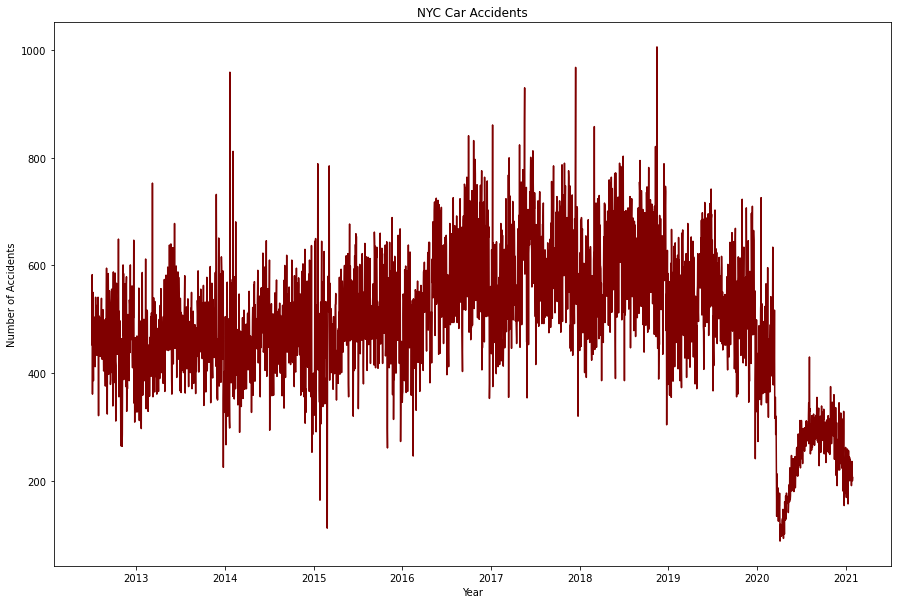

In [23]:
# Visualize total accidents per day
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(df_TS['Accidents_Total'],color='maroon', label='Total')
plt.title('NYC Car Accidents')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')

As we can see above, there was a precipitous drop in car accidents in early 2020, almost certainly attributed to decreased traffic at the start of the COVID-19 lockdown in New York. Let's zoom in a bit more to see a bit more clearly what this period looks like.

Text(0, 0.5, 'Number of Accidents')

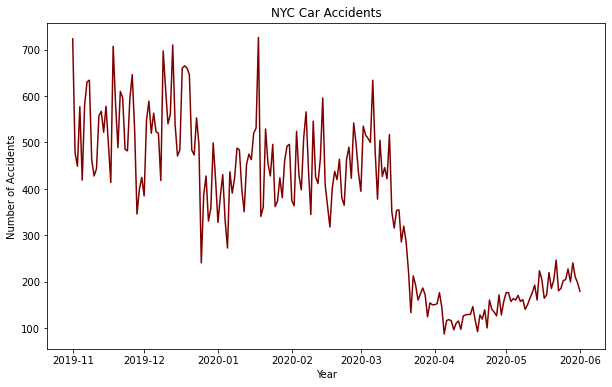

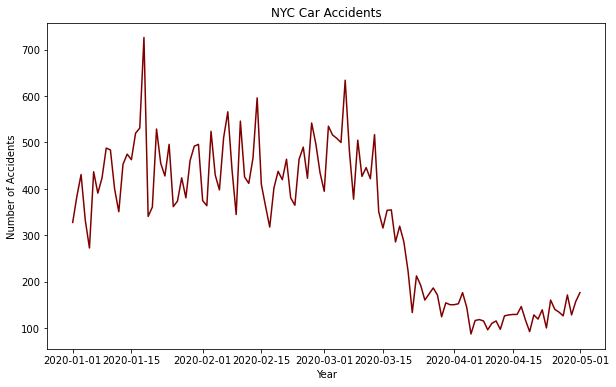

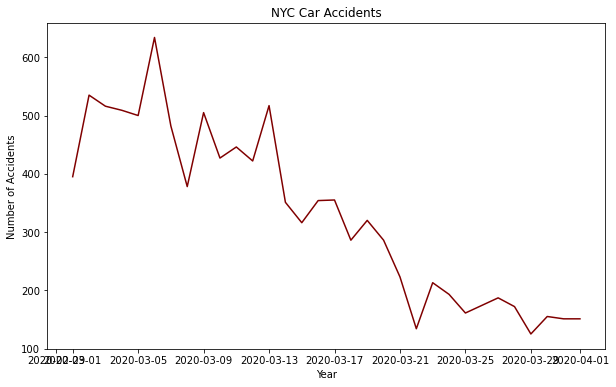

In [24]:
# Identify COVID drop cut-off--zoom in on early 2020
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(df_TS['Accidents_Total'].loc['2019-11-1':'2020-6-1'],color='maroon', label='Total')
plt.title('NYC Car Accidents')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')

fig2, ax2 = plt.subplots(figsize=(10,6))
plt.plot(df_TS['Accidents_Total'].loc['2020-1-1':'2020-5-1'],color='maroon', label='Total')
plt.title('NYC Car Accidents')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')

fig3, ax4 = plt.subplots(figsize=(10,6))
plt.plot(df_TS['Accidents_Total'].loc['2020-3-1':'2020-4-1'],color='maroon', label='Total')
plt.title('NYC Car Accidents')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')



Based on the above, we will consider 3/13/20 to be our cut-off point for when our "COVID data" begins. This is also consistent with the day NYC issued its full lockdown.

### Dealing with COVID data in a time series model

The steep drop in car accidents presents a challenge with a traditional time series model. We expect car accident frequency to approach "normalcy" again at some point, but to what extent? And when? Assuming no impact COVID will not be accurate, but neither will assume similar trends as we have seen since March.

#### The Research

Research to help decide how to approach the time series strategy included:
1. COVID projections
2. Transportation projections
3. Workforce projections

Sources for the below are included at the end of this notebook.

**COVID Projections**


Since car accidents are negatively correlated with COVID cases, looking at COVID case projections can give us insight regarding accident count.

-Numerous models predict a plateau of cumulative COVID deaths by June, with a linear trend until then.

-Numerous models predict approximaely 80% poulation COVID immunity in NYC by June, with a linear trend until then. 

**Transportation Projections**

Since more accidents occur with more cars on the road, looking at projections relating to traffic patterns and transportation in general will impact our own as well.

-NYC has planned 40% service cuts for its subway and bus service by 2022. It is expected that more people will drive as compared with pre-COVID transportation patterns, but this plan in cuts could also be indicative of fewer people traveling on a daily basis overall.

-There has been a rise in pedestrian streets, which has removed cars from downtown neighborhoods. These are expected to stay indefinitely, and could impact the number of cars on the road in more urban areas of NYC.

**Workforce Projections**

As more people return to working in offices, the number of cars on the road will increase.

-77% of office employees are currently working from home at least 1 day per week. 55% expect to continue doing so indefinitely.

-Estimates show that 10-20% of the US workforce could work from home indefinitely.

#### The Plan

While it is impossible to predict exactly what will happen over the coming months, based on the above information the plan to create as accurate an accident count prediction as possible is:
1. The time series model will be based on pre-COVID data.
2. Predictions will be aplied starting on July 1, 2021.
3. Predictions based on pre-COVID data will be diminished by 25%.
4. Between the end of the current dataset, January 2021, and the time series model starting in July, predictions will be applied linearly as a connection.

## EDA on Pre-COVID Data

Since our time series model will only apply to pre-COVID data, EDA will focus on this data as well, rather than the entire dataset.

In [25]:
# Create pre-COVID df
df_TS_preCOV = df_TS.loc[:'2020-3-13']
df_new_preCOV = df_new[df_new['Date']<='2020-3-13']

In [26]:
df_new_preCOV.head()

Date CRASH TIME    ZIP CODE   LATITUDE  LONGITUDE  \
10122 2016-03-17      10:00  10029-6408  40.776900 -73.941300   
14649 2020-03-04      19:00       10039  40.831700 -73.935394   
14650 2020-02-15      21:50       11359  40.763245 -73.758060   
23684 2020-03-13      23:00       11203  40.644073 -73.935394   
23843 2020-03-10      12:45       11224  40.580658 -73.985664   

                      LOCATION                    ON STREET NAME  \
10122      (40.7769, -73.9413)  Grand Central Pkwy                 
14649    (40.8317, -73.935394)  8 AVENUE                           
14650   (40.763245, -73.75806)  CROSS ISLAND PARKWAY               
23684  (40.644073, -73.935394)  CLARENDON ROAD                     
23843  (40.580658, -73.985664)  CROPSEY AVENUE                     

      CROSS STREET NAME OFF STREET NAME  NUMBER OF PERSONS INJURED  ...  \
10122               NaN             NaN                        1.0  ...   
14649               NaN             NaN                        0.0  ...   
14650               NaN             NaN                        0.0  ...   
23684               NaN             NaN                        0.0  ...   
23843               NaN             NaN                        1.0  ...   

       VEHICLE TYPE CODE 4  VEHICLE TYPE CODE 5                   LatLong_str  \
10122                  NaN                  NaN              40.7769,-73.9413   
14649                  NaN                  NaN    40.8317,-73.93539399999999   
14650                  NaN                  NaN           40.763245,-73.75806   
23684                  NaN                  NaN  40.644073,-73.93539399999999   
23843                  NaN                  NaN          40.580658,-73.985664   

                                                 Address  BOROUGH_Brooklyn  \
10122  {'road': 'John Finley Walk', 'neighbourhood': ...                 0   
14649  {'road': 'Frederick Douglass Boulevard', 'neig...                 0   
14650  {'road': 'Cross Island Parkway', 'neighbourhoo...                 0   
23684  {'house_number': '4324', 'road': 'Clarendon Ro...                 1   
23843  {'house_number': '3071', 'road': 'Cropsey Aven...                 1   

       BOROUGH_Manhattan  BOROUGH_Queens BOROUGH_Staten Island  \
10122                  1               0                     0   
14649                  1               0                     0   
14650                  0               1                     0   
23684                  0               0                     0   
23843                  0               0                     0   

      BOROUGH_The Bronx Accidents_Total  
10122                 0               1  
14649                 0               1  
14650                 0               1  
23684                 0               1  
23843                 0               1  

[5 rows x 36 columns]

**Number of Accidents by Borough**

<function matplotlib.pyplot.show(*args, **kw)>

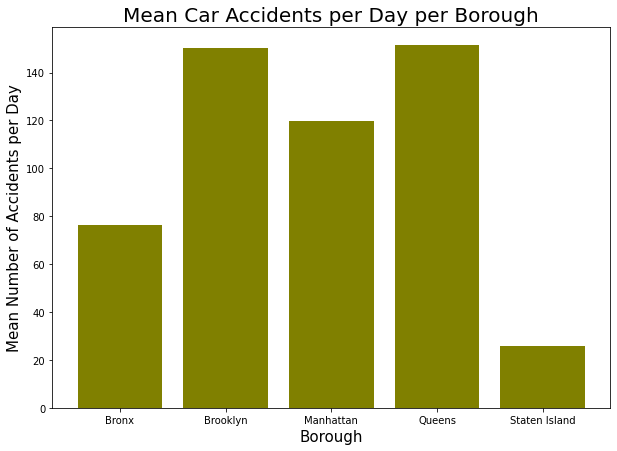

In [27]:
# Number of mean accidents per day per borough
fig, ax = plt.subplots(figsize=(10,7))
plt.bar(x=['Bronx','Brooklyn','Manhattan','Queens','Staten Island'],
        height=[df_TS_preCOV['Accidents_Bx'].mean(),df_TS['Accidents_Bkln'].mean(),df_TS_preCOV['Accidents_Man'].mean(),df_TS_preCOV['Accidents_Qns'].mean(),
                df_TS_preCOV['Accidents_SI'].mean()], color = 'olive')

plt.title("Mean Car Accidents per Day per Borough", fontsize=20)
plt.xlabel('Borough', fontsize=15)
plt.ylabel('Mean Number of Accidents per Day', fontsize=15)
plt.show

From the above, we see that Brooklyn and Queens have nearly identical mean accident counts. We will start with a time series model predicting car accidents in Brooklyn, since it has the higher accident-to-area ratio of the two.

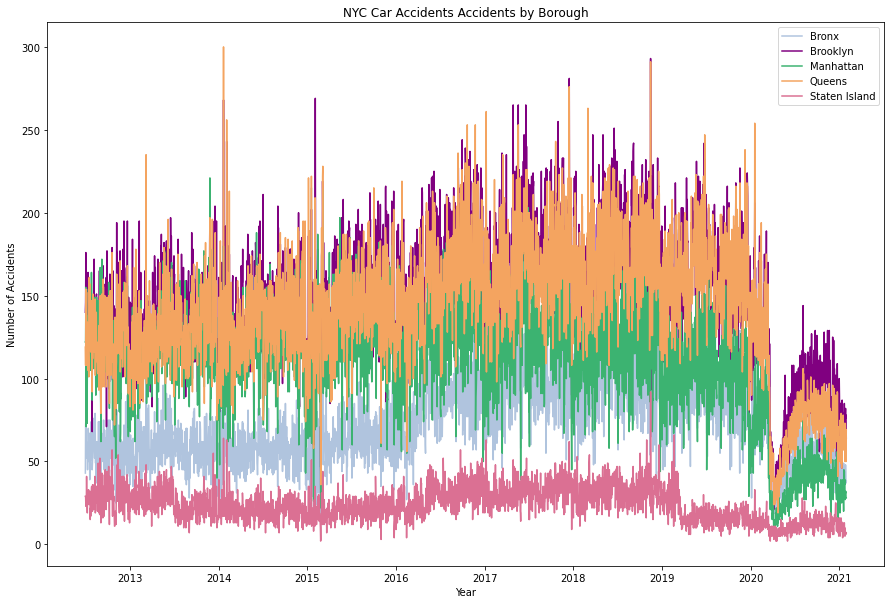

In [31]:
# Number of accidents over time by borough
# Note that this our only piece of EDA that incorporate post-COVID data as well,
# so we can see how each borough was impacted
fig, ax = plt.subplots(figsize=(15,10))

plt.plot(df_TS['Accidents_Bx'], color='lightsteelblue', label='Bronx')
plt.plot(df_TS['Accidents_Bkln'], color='purple', label='Brooklyn')
plt.plot(df_TS['Accidents_Man'], color='mediumseagreen', label='Manhattan')
plt.plot(df_TS['Accidents_Qns'], color='sandybrown', label='Queens')
plt.plot(df_TS['Accidents_SI'], color='palevioletred', label='Staten Island')

plt.legend(loc='best')
plt.title('NYC Car Accidents Accidents by Borough')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.show(block=False)

**Number of Car Accidents by Top Zip Codes**

In [32]:
# Turn zip codes into strings
df_new_preCOV['ZIP CODE'] = df_new_preCOV['ZIP CODE'].apply(str)

# Take only first 5 digits of each zip code (to prevent repetition)
df_new_preCOV['ZIP CODE'] = df_new_preCOV['ZIP CODE'].apply(lambda x: x[:5])

# Group by zip code
df_zip = df_new_preCOV.groupby(df_new_preCOV['ZIP CODE']).sum()

# Sort df_zip by most accidents
zip_acc = df_zip.sort_values(by = ['Accidents_Total'], ascending = False)

# Create lists of top 10 zip codes and their corresponding mean accident counts (ie total accidents/number of days)
top_zip = []
top_acc = []
for zipcode in zip_acc.index[:10]:
    top_zip.append(zipcode)
for acc_count in zip_acc['Accidents_Total'][:10]:
    top_acc.append(acc_count/len(df_TS_preCOV))


<function matplotlib.pyplot.show(*args, **kw)>

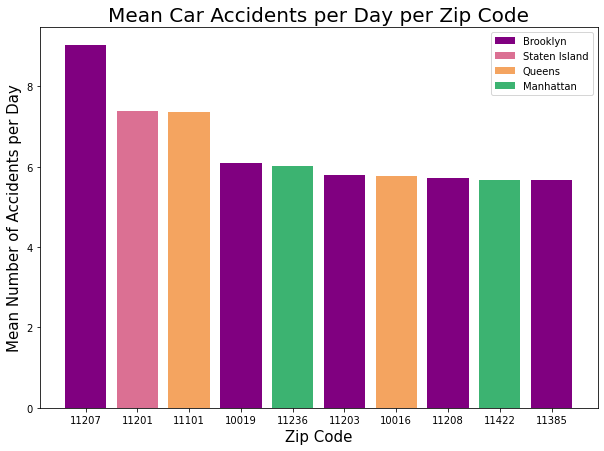

In [33]:
# Plot data by zip code
fig, ax = plt.subplots(figsize=(10,7))
plt.bar(x=top_zip[0],
        height=top_acc[0],
        color = 'purple',
        label = 'Brooklyn')
plt.bar(x=top_zip[1],
        height=top_acc[1],
        color = 'palevioletred',
        label = 'Staten Island')
plt.bar(x=top_zip[2],
        height=top_acc[2],
        color = 'sandybrown',
        label = 'Queens')
plt.bar(x=top_zip[3],
        height=top_acc[3],
        color = 'purple')
plt.bar(x=top_zip[4],
        height=top_acc[4],
        color = 'mediumseagreen',
        label = 'Manhattan')
plt.bar(x=top_zip[5],
        height=top_acc[5],
        color = 'purple')
plt.bar(x=top_zip[6],
        height=top_acc[6],
        color = 'sandybrown')
plt.bar(x=top_zip[7],
        height=top_acc[7],
        color = 'purple')
plt.bar(x=top_zip[8],
        height=top_acc[8],
        color = 'mediumseagreen')
plt.bar(x=top_zip[9],
        height=top_acc[9],
        color = 'purple')
            
plt.legend(loc='best')

plt.title("Mean Car Accidents per Day per Zip Code", fontsize=20)
plt.xlabel('Zip Code', fontsize=15)
plt.ylabel('Mean Number of Accidents per Day', fontsize=15)
plt.show

**Mean Accident Count on Holidays vs Non-Holidays**

In [57]:
df_TS_preCOV.groupby(df_TS_preCOV['Holiday']).mean()

Injuries    Deaths  Accidents_Bkln  Accidents_Man  Accidents_Qns  \
Holiday                                                                       
0        141.157411  0.618242      159.150055     121.656124     152.595439   
1        117.010638  0.585106      123.531915      71.095745     114.861702   

         Accidents_SI  Accidents_Bx  Accidents_Total   Weekend  
Holiday                                                         
0           25.922766     76.794042       536.118426  0.290180  
1           18.255319     59.202128       386.946809  0.148936

<function matplotlib.pyplot.show(*args, **kw)>

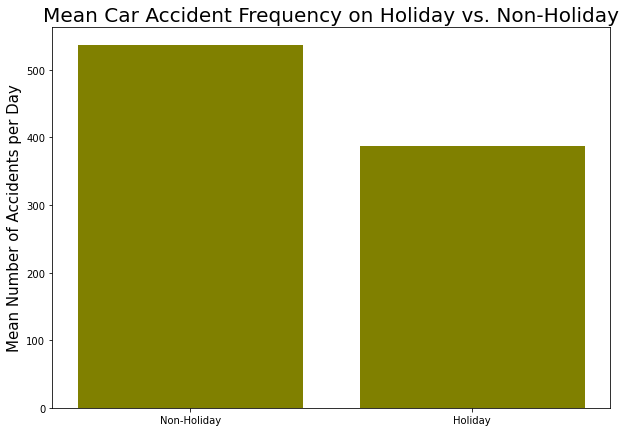

In [60]:
# Create TS-style df with pre-COVID data
df_TS_preCOV = df_TS.loc[:'2020-03-13']

avg_nothol = df_TS_preCOV.groupby(df_TS_preCOV['Holiday']).mean()['Accidents_Total'][0]
avg_hol = df_TS_preCOV.groupby(df_TS_preCOV['Holiday']).mean()['Accidents_Total'][1]

# Number of mean accidents on a holiday vs non-holiday
fig, ax = plt.subplots(figsize=(10,7))
plt.bar(x=['Non-Holiday', 'Holiday'],
        height=[avg_nothol, avg_hol], color = 'olive')

plt.title("Mean Car Accident Frequency on Holiday vs. Non-Holiday", fontsize=20)
plt.ylabel('Mean Number of Accidents per Day', fontsize=15)
plt.show


**Mean Accident Count by Weekday**

<function matplotlib.pyplot.show(*args, **kw)>

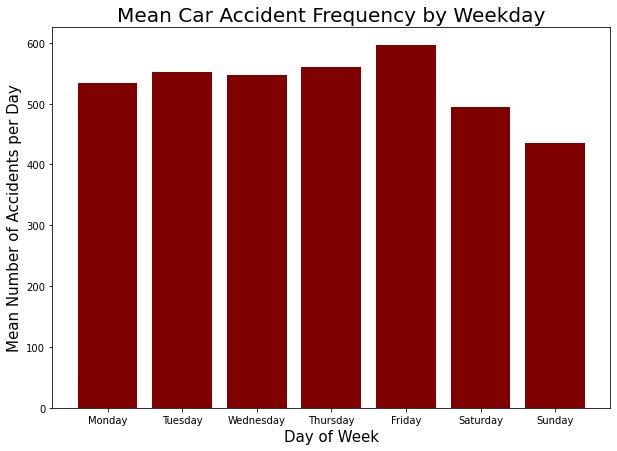

In [50]:
mon = df_TS_preCOV.groupby(df_TS_preCOV['Day of Week']).mean()['Accidents_Total'][1]
tues = df_TS_preCOV.groupby(df_TS_preCOV['Day of Week']).mean()['Accidents_Total'][5]
wed = df_TS_preCOV.groupby(df_TS_preCOV['Day of Week']).mean()['Accidents_Total'][6]
thurs = df_TS_preCOV.groupby(df_TS_preCOV['Day of Week']).mean()['Accidents_Total'][4]
fri = df_TS_preCOV.groupby(df_TS_preCOV['Day of Week']).mean()['Accidents_Total'][0]
sat = df_TS_preCOV.groupby(df_TS_preCOV['Day of Week']).mean()['Accidents_Total'][2]
sun = df_TS_preCOV.groupby(df_TS_preCOV['Day of Week']).mean()['Accidents_Total'][3]

# Number of mean accidents on a holiday vs non-holiday
fig, ax = plt.subplots(figsize=(10,7))
plt.bar(x=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
        height=[mon, tues, wed, thurs, fri, sat, sun], color = 'maroon')

plt.title("Mean Car Accident Frequency by Weekday", fontsize=20)
plt.xlabel('Day of Week', fontsize=15)
plt.ylabel('Mean Number of Accidents per Day', fontsize=15)
plt.show


**Mean Accident Count by Season**

In [51]:
df_TS_preCOV.groupby(df_TS_preCOV['Season']).mean()['Accidents_Total']

Season
Fall      537.737772
Spring    559.257457
Summer    534.608696
Winter    495.149148
Name: Accidents_Total, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

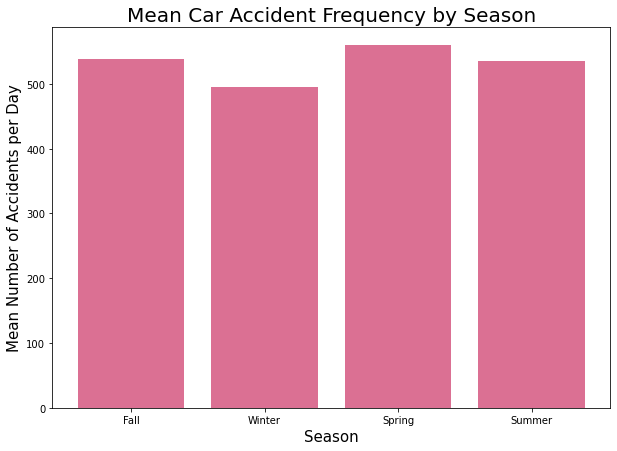

In [52]:
fall = df_TS_preCOV.groupby(df_TS_preCOV['Season']).mean()['Accidents_Total'][0]
winter = df_TS_preCOV.groupby(df_TS_preCOV['Season']).mean()['Accidents_Total'][3]
spring = df_TS_preCOV.groupby(df_TS_preCOV['Season']).mean()['Accidents_Total'][1]
summer = df_TS_preCOV.groupby(df_TS_preCOV['Season']).mean()['Accidents_Total'][2]


# Number of mean accidents per season
fig, ax = plt.subplots(figsize=(10,7))
plt.bar(x=['Fall', 'Winter', 'Spring', 'Summer'],
        height=[fall, winter, spring, summer], color = 'palevioletred')

plt.title("Mean Car Accident Frequency by Season", fontsize=20)
plt.xlabel('Season', fontsize=15)
plt.ylabel('Mean Number of Accidents per Day', fontsize=15)
plt.show


# Export Data

In [218]:
# Export time series dataset for modeling notebook
df_TS.to_csv('Data/df_TS.csv')

In [28]:
# Export df_new for streamlit dashboard
# Remove null lat/long values
df_latlong = df_new[~df_new['LATITUDE'].isna()]
df_latlong = df_new[~df_new['LONGITUDE'].isna()]

# Export data
df_latlong.to_csv('Data/df_latlong.csv')


# COVID/Transportation/Workforce Trend Sources

https://www.cdc.gov/coronavirus/2019-ncov/downloads/covid-data/Consolidated-Forecasts-Incident-Cumulative-Deaths-2021-02-01.pdf

https://covid19.healthdata.org/united-states-of-america?view=total-deaths&tab=trend

https://analytics-tools.shinyapps.io/covid19simulator04/

https://covid19-projections.com/path-to-herd-immunity/

https://www.theatlantic.com/ideas/archive/2020/12/the-2021-post-pandemic-prediction-palooza/617332/

https://www.govtech.com/analytics/Has-COVID-19-Forever-Changed-Rush-Hour-Traffic-Patterns.html